In [1]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback, EarlyStopping, ModelCheckpoint

In [2]:
DATA_PATH = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/'

class config:
    batch_size = 16
    lr = 0.0001
    max_epochs = 30
    early_stopping_patience = 5

In [3]:
def mask_of(file_path):
    """
    get file path of masked image
    example: TCGA_CS_4941_19960909_1.tif -> TCGA_CS_4941_19960909_1_mask.tif
    """
    body = file_path[:-4]
    return body + '_mask.tif'

In [4]:
# get all original image files
file_list = []

for f in glob.glob(DATA_PATH+'**', recursive=True):
    if os.path.isfile(f) and f[-3:] == 'tif':
        if f[-8:-4] != 'mask':
            file_list.append(f)
            
print('data size:', len(file_list))

data size: 3929


## Visualization

img.shape:   (256, 256, 3)
mask.shape:  (256, 256)


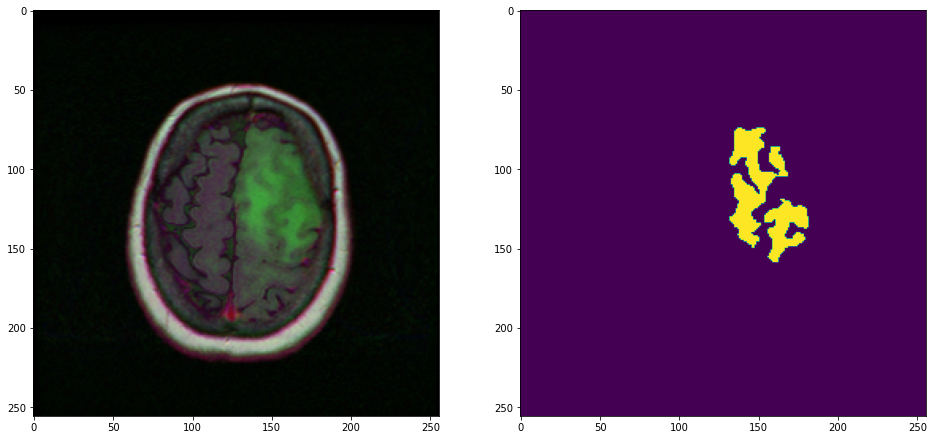

In [5]:
file = file_list[0]
img = cv2.imread(file)
mask = cv2.imread(mask_of(file), 0)

print('img.shape:  ', img.shape)
print('mask.shape: ', mask.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(img)
ax[1].imshow(mask)

## Dataset & DataLoader

In [6]:
transform = A.Compose([
    A.Normalize(p=1.0),
    ToTensorV2()
])

In [7]:
class BrainMriDataset(Dataset):
    def __init__(self, file_list, transform, train=True):
        self.file_list = file_list
        self.train = train
        self.transform = transform
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        file = file_list[idx]
        img = cv2.imread(file)
        mask = cv2.imread(mask_of(file), 0).clip(0, 1).astype('float32')[np.newaxis, :]
        transformed = transform(image=img, mask=mask)
        img, mask = transformed['image'], transformed['mask']
        if not self.train:
            return img
        else:
            return img, mask

In [8]:
n_train = 2000
data = BrainMriDataset(file_list[:n_train], transform=transform, train=True)
data_te = BrainMriDataset(file_list[n_train:], transform=transform, train=True)

n = len(data)
data_tr, data_va = random_split(data, [int(0.8*n), int(0.2*n)])

dataloader_tr = DataLoader(data_tr, batch_size=config.batch_size, shuffle=True)
dataloader_va = DataLoader(data_va, batch_size=config.batch_size)
dataloader_te = DataLoader(data_te, batch_size=config.batch_size)

## Model: U-Net

In [9]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.double_conv(x)
        return x


class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.down_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        x = self.down_conv(x)
        return x


class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(
            in_channels=in_channels,
            out_channels=in_channels // 2,
            kernel_size=2,
            stride=2,
        )
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], dim=1)
        x = self.conv(x)
        return x

In [10]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = DoubleConv(in_channels=3, out_channels=64)
        self.down1 = DownConv(in_channels=64, out_channels=128)
        self.down2 = DownConv(in_channels=128, out_channels=256)
        self.down3 = DownConv(in_channels=256, out_channels=512)
        self.up3 = UpConv(in_channels=512, out_channels=256)
        self.up2 = UpConv(in_channels=256, out_channels=128)
        self.up1 = UpConv(in_channels=128, out_channels=64)
        self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)

    def forward(self, x):
        x1 = self.conv(x)  # (3, 256, 256) -> (64, 256, 256)
        x2 = self.down1(x1)  # (64, 256, 256) -> (128, 128, 128)
        x3 = self.down2(x2)  # (128, 128, 128) -> (256, 64, 64)
        x = self.down3(x3)  # (256, 64, 64) -> (512, 32, 32)
        x = self.up3(x, x3)  # (512, 32, 32) -> (256, 64, 64)
        x = self.up2(x, x2)  # (256, 64, 64) -> (128, 128, 128)
        x = self.up1(x, x1)  # (128, 128, 128) -> (64, 256, 256)
        out = self.out(x)  # (64, 256, 256) -> (1, 256, 256)
        return torch.sigmoid(out)

## Loss

In [11]:
def dice_coef_loss(y_hat, y):
    smooth = 1.0
    intersection = 2.0 * ((y * y_hat).sum()) + smooth
    union = y.sum() + y_hat.sum() + smooth

    return 1 - (intersection / union)


def bce_dice_loss(y_hat, y):
    dicescore = dice_coef_loss(y_hat, y)
    bcescore = nn.BCELoss()
    bceloss = bcescore(y_hat, y)

    return bceloss + dicescore

In [12]:
class UNetPL(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.model = UNet()
        self.loss_fn = bce_dice_loss
        self.config = config

    def forward(self, x):
        x = self.model(x)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config.lr)
        return optimizer

    def training_step(self, batch, batch_index):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_index):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log("valid_loss", loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log("test_loss", loss)
        return loss
    
    def training_epoch_end(self, outputs):
        print(f"epoch: {self.current_epoch} / {self.config.max_epochs}")
        loss = (sum(output['loss'] for output in outputs) / len(outputs)).item()
        print("train loss:", loss)
        
    def validation_epoch_end(self, outputs):
        loss = (sum(outputs) / len(outputs)).item()
        print("valid loss:", loss)

## Train

In [13]:
callback_checkpoint = ModelCheckpoint(dirpath='/kaggle/working/', save_top_k=1, monitor='valid_loss')
callback_earlystopping = EarlyStopping(monitor='valid_loss', patience=config.early_stopping_patience)
callbacks = [callback_checkpoint, callback_earlystopping]

model = UNetPL(config)
trainer = pl.Trainer(max_epochs=config.max_epochs, callbacks=callbacks, accelerator='gpu')

trainer.fit(model, dataloader_tr, dataloader_va)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /kaggle/working exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Sanity Checking: 0it [00:00, ?it/s]

valid loss: 1.6700387001037598


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

valid loss: 0.8126741051673889
epoch: 0 / 30
train loss: 1.102786898612976


Validation: 0it [00:00, ?it/s]

valid loss: 0.7007957100868225
epoch: 1 / 30
train loss: 0.7251917719841003


Validation: 0it [00:00, ?it/s]

valid loss: 0.6306684613227844
epoch: 2 / 30
train loss: 0.642689049243927


Validation: 0it [00:00, ?it/s]

valid loss: 0.6138703227043152
epoch: 3 / 30
train loss: 0.6200703978538513


Validation: 0it [00:00, ?it/s]

valid loss: 0.6218261122703552
epoch: 4 / 30
train loss: 0.6192471981048584


Validation: 0it [00:00, ?it/s]

valid loss: 0.6273017525672913
epoch: 5 / 30
train loss: 0.6242084503173828


Validation: 0it [00:00, ?it/s]

valid loss: 0.602279007434845
epoch: 6 / 30
train loss: 0.6137914657592773


Validation: 0it [00:00, ?it/s]

valid loss: 0.6039199829101562
epoch: 7 / 30
train loss: 0.6085858941078186


Validation: 0it [00:00, ?it/s]

valid loss: 0.6160009503364563
epoch: 8 / 30
train loss: 0.5801752209663391


Validation: 0it [00:00, ?it/s]

valid loss: 0.5772551894187927
epoch: 9 / 30
train loss: 0.5673684477806091


Validation: 0it [00:00, ?it/s]

valid loss: 0.5783292651176453
epoch: 10 / 30
train loss: 0.5933915376663208


Validation: 0it [00:00, ?it/s]

valid loss: 0.5409042835235596
epoch: 11 / 30
train loss: 0.5619677305221558


Validation: 0it [00:00, ?it/s]

valid loss: 0.5243865251541138
epoch: 12 / 30
train loss: 0.5338922739028931


Validation: 0it [00:00, ?it/s]

valid loss: 0.5430343747138977
epoch: 13 / 30
train loss: 0.5161124467849731


Validation: 0it [00:00, ?it/s]

valid loss: 0.5073538422584534
epoch: 14 / 30
train loss: 0.5164453983306885


Validation: 0it [00:00, ?it/s]

valid loss: 0.5798628330230713
epoch: 15 / 30
train loss: 0.5375365614891052


Validation: 0it [00:00, ?it/s]

valid loss: 0.5265066027641296
epoch: 16 / 30
train loss: 0.5546637773513794


Validation: 0it [00:00, ?it/s]

valid loss: 0.570452094078064
epoch: 17 / 30
train loss: 0.5320272445678711


Validation: 0it [00:00, ?it/s]

valid loss: 0.4817415177822113
epoch: 18 / 30
train loss: 0.4862991273403168


Validation: 0it [00:00, ?it/s]

valid loss: 0.552724301815033
epoch: 19 / 30
train loss: 0.48191842436790466


Validation: 0it [00:00, ?it/s]

valid loss: 0.5980796813964844
epoch: 20 / 30
train loss: 0.4599476456642151


Validation: 0it [00:00, ?it/s]

valid loss: 0.46960002183914185
epoch: 21 / 30
train loss: 0.5170661807060242


Validation: 0it [00:00, ?it/s]

valid loss: 0.5200901031494141
epoch: 22 / 30
train loss: 0.454102098941803


Validation: 0it [00:00, ?it/s]

valid loss: 0.399955689907074
epoch: 23 / 30
train loss: 0.4367145001888275


Validation: 0it [00:00, ?it/s]

valid loss: 0.4276546835899353
epoch: 24 / 30
train loss: 0.4145222306251526


Validation: 0it [00:00, ?it/s]

valid loss: 0.3546278178691864
epoch: 25 / 30
train loss: 0.39376306533813477


Validation: 0it [00:00, ?it/s]

valid loss: 0.3705001473426819
epoch: 26 / 30
train loss: 0.3975391983985901


Validation: 0it [00:00, ?it/s]

valid loss: 0.40130725502967834
epoch: 27 / 30
train loss: 0.38458937406539917


Validation: 0it [00:00, ?it/s]

valid loss: 0.3540176451206207
epoch: 28 / 30
train loss: 0.3560904562473297


Validation: 0it [00:00, ?it/s]

valid loss: 0.41562801599502563
epoch: 29 / 30
train loss: 0.4435986578464508


## Test

In [14]:
trainer.test(dataloaders=dataloader_te, ckpt_path='best')

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.4580785632133484     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.4580785632133484}]

## Predict

In [15]:
data_te_x = BrainMriDataset(file_list[n_train:], transform=transform, train=False)
dataloader_te_x = DataLoader(data_te_x, batch_size=1)
preds = trainer.predict(dataloaders=dataloader_te_x, ckpt_path='best')

Predicting: 100it [00:00, ?it/s]

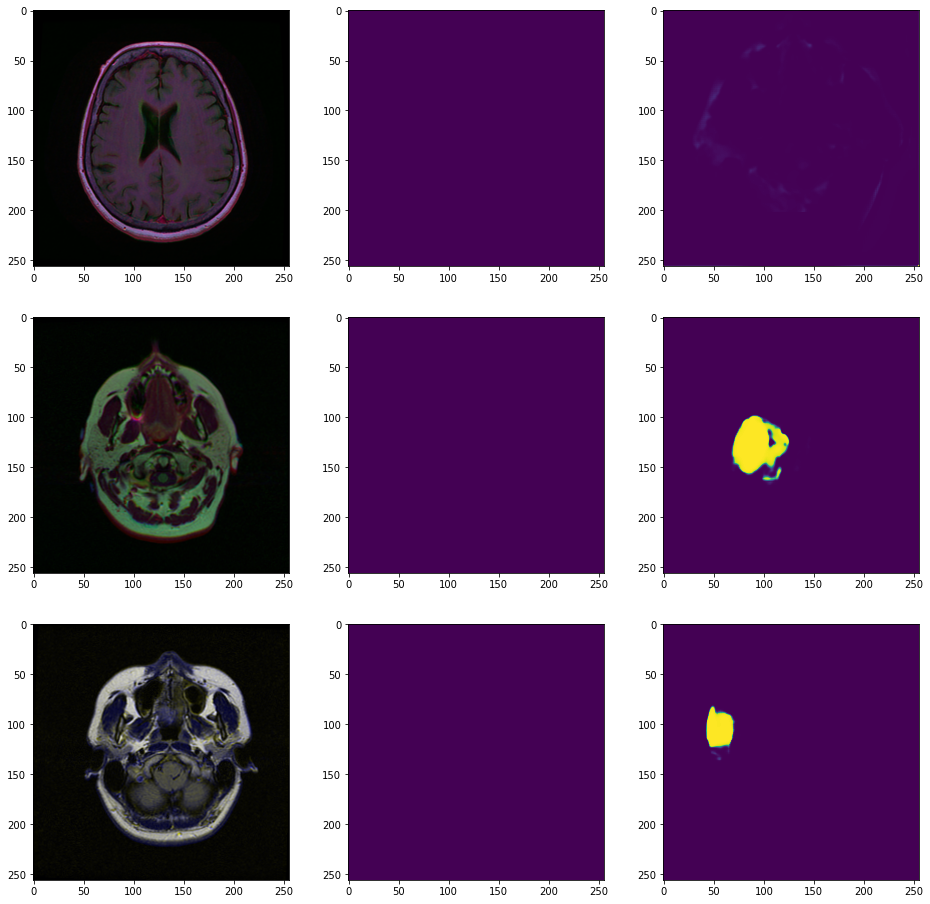

In [16]:
idx_list = [444, 400, 700]
fig, ax = plt.subplots(len(idx_list), 3, figsize=(16, 16))

for i, idx in enumerate(idx_list):
    file = file_list[n_train+idx]
    img = cv2.imread(file)
    mask = cv2.imread(mask_of(file), 0)
    pred = torch.squeeze(preds[idx])

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(mask)
    ax[i, 2].imshow(pred)